In [ ]:
!pip list -q

In [ ]:
import tensorflow as tf

In [ ]:
!pip install matplotlib -q

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/NewTraining1/Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9000 files belonging to 3 classes.


In [ ]:
# from pathlib import Path
# import imghdr

# data_dir = "C:\\Coding\\CasssavaleavesDiseaseClassification\\training\dataset"
# image_extensions = [".png", ".jpg",".bmp",".gif"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
class_names = dataset.class_names
class_names

['Alternaria_Leaf_Blight', 'Healthy', 'Potassium_Deficiency']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 0 1 0 0 1 2 2 0 1 2 2 2 2 1 2 1 0 2 0 1 1 0 0 0 1 0 1 1 0 1]


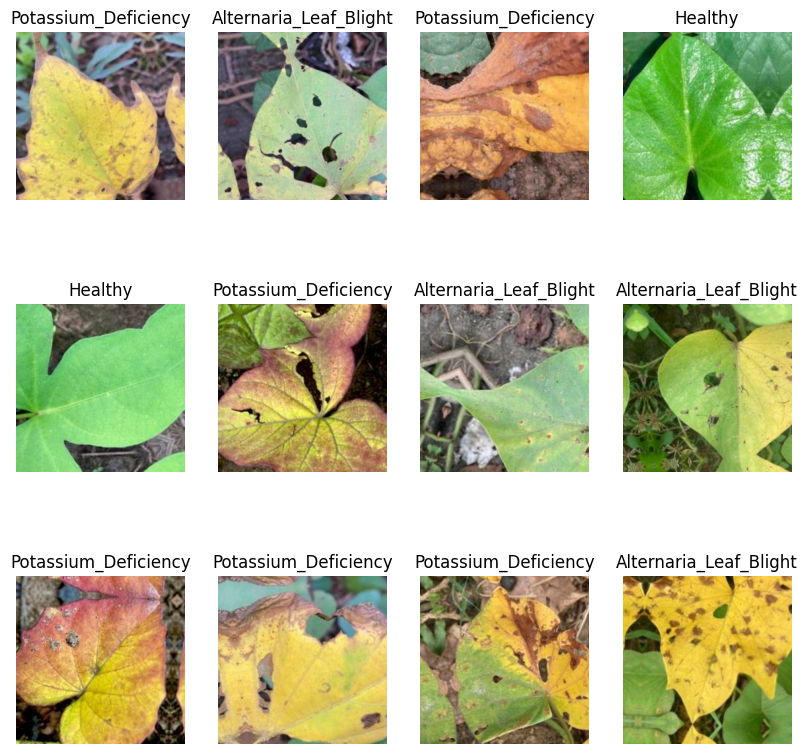

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
dataset.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(dataset)

282

In [ ]:
size_train = 0.8
len(dataset)*size_train

225.60000000000002

In [ ]:
dt_train = dataset.take(225)
len(dt_train)

225

In [ ]:
dt_test = dataset.skip(200)
len(dt_test)

82

In [ ]:
size_val=0.1
len(dataset)*size_val

28.200000000000003

In [ ]:
dt_val = dt_test.take(28)
len(dt_val)

28

In [ ]:
dt_test = dt_test.skip(28)
len(dt_test)

54

In [ ]:
def get_dataset_partitions_tf(ds, split_train=0.8, split_val=0.1, split_test=0.1, shuffle=True, shuffle_size=10000):
    assert (split_train + split_test + split_val) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    size_train = int(split_train * ds_size)
    val_size = int(split_val * ds_size)
    
    dt_train = ds.take(size_train)    
    dt_val = ds.skip(size_train).take(val_size)
    dt_test = ds.skip(size_train).skip(val_size)
    
    return dt_train, dt_val, dt_test

In [ ]:
dt_train, dt_val, dt_test = get_dataset_partitions_tf(dataset)

In [ ]:
len(dt_train)

225

In [ ]:
len(dt_val)

28

In [ ]:
len(dt_test)

29

In [ ]:
dt_train = dt_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dt_val = dt_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dt_test = dt_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building



In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

# Augmentation to Training Dataset

# Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

# Compiling the Model

# Early Stopping

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd

early_stop = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    dt_train,
    batch_size=BATCH_SIZE,
    validation_data=dt_val,
    verbose=1, 
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)
# convert the history.history dict to a pandas DataFrame:  
hist_df = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = r"/Users/near8east/Desktop/Matthias/Training/history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


Epoch 1/30
225/225 [==============================] - 219s 944ms/step - loss: 0.5279 - accuracy: 0.7435 - val_loss: 0.5044 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 2/30
225/225 [==============================] - 193s 856ms/step - loss: 0.4574 - accuracy: 0.7800 - val_loss: 0.4094 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 3/30
225/225 [==============================] - 189s 838ms/step - loss: 0.4249 - accuracy: 0.7949 - val_loss: 0.4543 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 4/30
225/225 [==============================] - 189s 841ms/step - loss: 0.4079 - accuracy: 0.8039 - val_loss: 0.3944 - val_accuracy: 0.8114 - lr: 0.0010
Epoch 5/30
225/225 [==============================] - 193s 858ms/step - loss: 0.3824 - accuracy: 0.8162 - val_loss: 0.3792 - val_accuracy: 0.8103 - lr: 0.0010
Epoch 6/30
225/225 [==============================] - 195s 865ms/step - loss: 0.3661 - accuracy: 0.8233 - val_loss: 0.3250 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 7/30
225/225 [==========================

In [ ]:
scores = model.evaluate(dt_test)

29/29 [==============================] - 14s 178ms/step - loss: 0.0753 - accuracy: 0.9860


In [ ]:
valloss = history.history['val_loss']
loss = history.history['loss']
acc = history.history['accuracy']
valacc = history.history['val_accuracy']
curves = pd.DataFrame()
curves["loss"] = loss
curves["accuracy"] = acc
curves["val_loss"] = valloss
curves["val_accuracy"] = valacc
curves.to_csv(r"/Users/near8east/Desktop/Matthias/Training/accuracy_loss.csv")
curves.head(3)

In [ ]:
scores

[0.07529181987047195, 0.985991358757019]

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 225}

In [ ]:
history.history.keys()

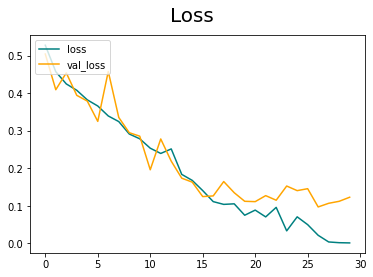

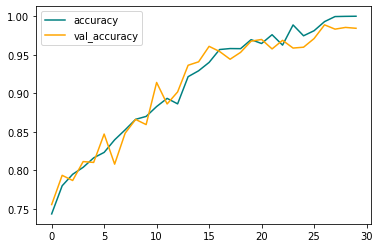

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


vvfig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [ ]:
pip install seaborn -q


first image for prediction
actual label: Alternaria_Leaf_Blight
1/1 [==============================] - 0s 221ms/step
predicted label: Alternaria_Leaf_Blight


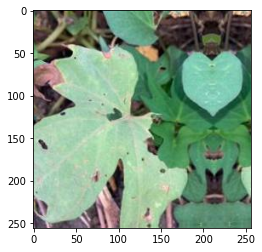

In [ ]:
import numpy as np
for images_batch, labels_batch in dt_test.take(1):
    
    first_img = images_batch[0].numpy().astype('uint8')
    first_lbl = labels_batch[0].numpy()
    
    print("first image for prediction")
    plt.imshow(first_img)
    print("actual label:",class_names[first_lbl])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Inference Function

In [ ]:
def predict(model, img):
    array_img = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    array_img = tf.expand_dims(array_img, 0)

    predictions = model.predict(array_img)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Apply Inference on images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in dt_test.take(6):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
        
        

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save("./sweetpotatoes.h5")

# Model Saving

In [ ]:
model_version=1
model.save(f"./newModels/{model_version}")

INFO:tensorflow:Assets written to: ./newModels/1/assets


INFO:tensorflow:Assets written to: ./newModels/1/assets


In [ ]:
model_version=2
model.save(f"../myModels/{model_version}")

In [ ]:
model_version=3
model.save(f"../myModels/{model_version}")

1/1 [==============================] - 0s 23ms/step


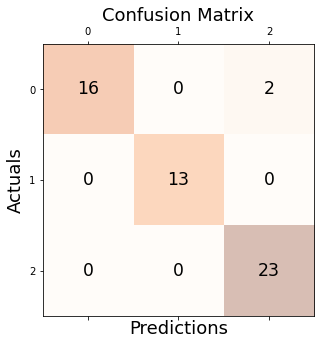

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

actual = []
pred = []
for images, labels in dt_test.take(6):
    for i in range(9):
        predicted_class, confidence = predict(model, images[i].numpy())
        pred.append(predicted_class)
        actual_class = class_names[labels[i]] 
        actual.append(actual_class)



conf_matrix = confusion_matrix(y_true=actual, y_pred=pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

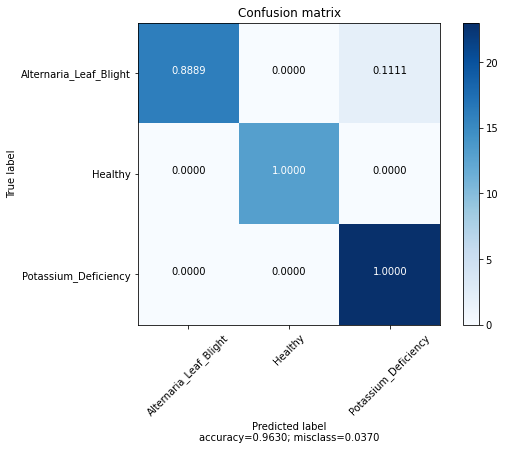

In [ ]:
plot_confusion_matrix(cm=conf_matrix,
                          target_names = ['Alternaria_Leaf_Blight', 'Healthy', 'Potassium_Deficiency'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load the test data
# test_images, test_labels = load_data(test_dir)

# Make predictions on the test data
y_pred = pred
y_pred_classes = pred
y_true = actual

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


# define the confusion matrix
conf_mat = cm

# get the number of classes
num_classes = len(conf_mat)

# initialize variables for true positives, false positives, false negatives, and true negatives
tp = [0] * num_classes
fp = [0] * num_classes
fn = [0] * num_classes
tn = 0

# calculate tp, fp, and fn for each class
for i in range(num_classes):
    tp[i] = conf_mat[i, i]
    fp[i] = np.sum(conf_mat[:, i]) - tp[i]
    fn[i] = np.sum(conf_mat[i, :]) - tp[i]

# calculate tn
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            tn += conf_mat[i, j]

tp = np.sum(tp)
fp = np.sum(fp)
fn = np.sum(fn)
            
accuracy = accuracy_score(y_true, y_pred_classes)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1],
    'Specificity': [specificity],
    'True Positive': [tp],
    'False Positive': [fp],
    'False Negative': [fn],
    'True Negative': [tn]
})

# Display the metrics as a table
metrics_df.transpose()


0
Accuracy         0.962963
Precision        0.962963
Recall           0.962963
F1-score         0.962963
Specificity      0.500000
True Positive   52.000000
False Positive   2.000000
False Negative   2.000000
True Negative    2.000000

In [ ]:
tp

[16, 13, 23]

In [ ]:
import numpy as np

# define the confusion matrix
conf_mat = conf_matrix

# get the number of classes
num_classes = len(conf_mat)

# initialize variables for true positives, false positives, false negatives, and true negatives
tp = [0] * num_classes
fp = [0] * num_classes
fn = [0] * num_classes
tn = 0

# calculate tp, fp, and fn for each class
for i in range(num_classes):
    tp[i] = conf_mat[i, i]
    fp[i] = np.sum(conf_mat[:, i]) - tp[i]
    fn[i] = np.sum(conf_mat[i, :]) - tp[i]

# calculate tn
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            tn += conf_mat[i, j]

# print the results
print("True Positives: ", tp)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Negatives: ", tn)


True Positives:  [16, 13, 23]
False Positives:  [0, 0, 2]
False Negatives:  [2, 0, 0]
True Negatives:  2


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Generate some sample data
y_true = actual
y_pred = pred

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Create a DataFrame to store the results
results_df = pd.DataFrame(conf_mat, index=['True 0', 'True 1', 'True 2'], columns=['Pred 0', 'Pred 1', 'Pred 2'])

# Compute the classification report
class_report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'], output_dict=True)

# Add accuracy, macro avg and weighted avg to the DataFrame
results_df.loc['Accuracy'] = np.round(np.diag(conf_mat)/conf_mat.sum(axis=1), 2)
results_df.loc['Macro Avg'] = np.round(pd.Series(class_report['macro avg']), 2)
results_df.loc['Weighted Avg'] = np.round(pd.Series(class_report['weighted avg']), 2)

# Print the results
print(results_df)


              Pred 0  Pred 1  Pred 2
True 0         16.00     0.0     2.0
True 1          0.00    13.0     0.0
True 2          0.00     0.0    23.0
Accuracy        0.89     1.0     1.0
Macro Avg        NaN     NaN     NaN
Weighted Avg     NaN     NaN     NaN


In [ ]:
model.save("../sweetpotatoes.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
res = pd.DataFrame()
res["Actual"] = actual
res["Predicted"]= pred
res.to_csv(r"C:\\DL\\Sweet_Potato_Leaf_Disease\\CSV\\actual_predicted.csv")

In [ ]:
file = pd.read_csv(r"C:\\DL\\Sweet_Potato_Leaf_Disease\\CSV\\actual_predicted.csv")
file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define empty lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Loop through the test data and predict the labels for each batch
for images, labels in dt_test:
    predicted_batch = model.predict(images)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predicted_batch, axis=1))

# Compute the confusion matrix for the overall test data
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


first image for prediction
actual label: Healthy
1/1 [==============================] - 2s 2s/step
predicted label: Healthy


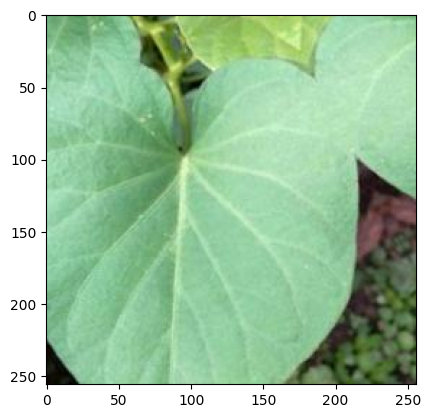

In [ ]:
import numpy as np
from tensorflow import keras

# Load the model from the h5 file
model = keras.models.load_model('/content/drive/MyDrive/NewTraining1/sweetpotatoes.h5')


import numpy as np
for images_batch, labels_batch in dt_test.take(1):
    
    first_img = images_batch[0].numpy().astype('uint8')
    first_lbl = labels_batch[0].numpy()
    
    print("first image for prediction")
    plt.imshow(first_img)
    print("actual label:",class_names[first_lbl])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])